# import libraries

In [1]:
import pandas as pd
import numpy as np
from numpy.random import RandomState
import matplotlib.pyplot as plt
from tqdm import tqdm

seed = 42
rng = RandomState(seed)

df = pd.read_csv('Model.csv',index_col = False)

X, y = df.iloc[:, 1:-1], df.iloc[:, -1]
print(X.shape, y.shape)

(12529, 59) (12529,)


In [2]:
X.head()

,destination_Home,destination_No Urgent Place,destination_Work,passanger_Alone,passanger_Friend(s),passanger_Kid(s),passanger_Partner,weather_Rainy,weather_Snowy,weather_Sunny,...,Restaurant20To50,income,education,age,time,expiration,driving_distance,gender,has_children,direction_opp
0,0,1,0,1,0,0,0,0,0,1,...,2,3,2,1,1,1,0,0,1,1
1,0,1,0,0,1,0,0,0,0,1,...,2,3,2,1,0,0,0,0,1,1
2,0,1,0,0,1,0,0,0,0,1,...,2,3,2,1,0,0,1,0,1,1
3,0,1,0,0,1,0,0,0,0,1,...,2,3,2,1,1,0,1,0,1,1
4,0,1,0,0,1,0,0,0,0,1,...,2,3,2,1,1,1,1,0,1,1


In [3]:
y.head()

0    1
1    0
2    1
3    0
4    0
Name: Y, dtype: int64

# train-test split

In [4]:
from sklearn.model_selection import train_test_split, cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, 
                                                    random_state=seed)
print('Train set: ', X_train.shape, y_train.shape)
print('Test set: ', X_test.shape, y_test.shape)

Train set:  (10023, 59) (10023,)
Test set:  (2506, 59) (2506,)


# cross val score using roc-auc

In [5]:
def cross_validation_score(estimator):
    scores = cross_val_score(
        estimator, X_train, y_train, cv=10, n_jobs=-1,
        scoring='roc_auc'
    )
    
    return scores.mean(), scores.std()


def plot_cross_validation(title, X, Y, error, xlabel, ylabel='ROC AUC'):
    plt.title(title)
    plt.grid()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.errorbar(X, Y, error, linestyle='None', marker='o')

# random forest for gini and entropy

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:09<00:00,  4.85s/it]


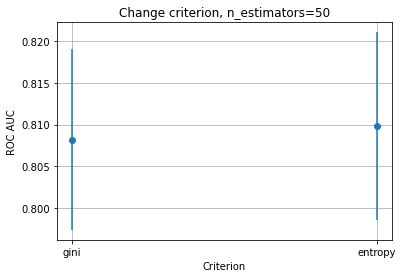

In [6]:
from sklearn.ensemble import RandomForestClassifier

title = 'Change criterion, n_estimators=50'
xlabel = 'Criterion'
criterions = ['gini', 'entropy']
means = []
stddevs = []

for criterion in tqdm(criterions):
    clf = RandomForestClassifier(criterion=criterion, n_estimators=50, 
                                 random_state=rng)
    mean, std = cross_validation_score(clf)
    means.append(mean)
    stddevs.append(std)
    
plot_cross_validation(title, criterions, means, stddevs, xlabel)
plt.savefig('RF_change_criterion.png')
plt.show()

# Change n_estimators, criterion=entropy

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:54<00:00, 10.91s/it]


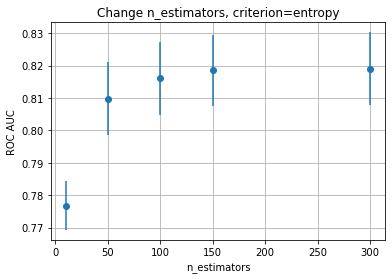

In [7]:
title = 'Change n_estimators, criterion=entropy'
xlabel = 'n_estimators'
N = [10, 50, 100, 150, 300]
means = []
stddevs = []

for n in tqdm(N):
    clf = RandomForestClassifier(criterion='entropy', n_estimators=n, 
                                 random_state=rng)
    mean, std = cross_validation_score(clf)
    means.append(mean)
    stddevs.append(std)

plot_cross_validation(title, N, means, stddevs, xlabel)
plt.savefig('RF_change_n_estimators.png')
plt.show()

# ROC-AUC

In [8]:
from sklearn.metrics import roc_auc_score, accuracy_score

rf = RandomForestClassifier(criterion='entropy', n_estimators=100, 
                            random_state=rng)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print('Accuracy on test set: ', accuracy_score(y_test, y_pred))
print('ROC AUC on test set: ', roc_auc_score(y_test, y_pred))

Accuracy on test set:  0.7545889864325619
ROC AUC on test set:  0.7452392969922865


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


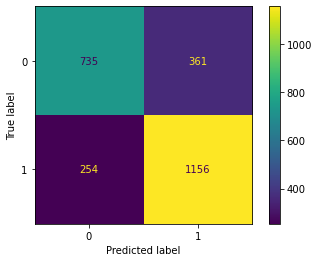

In [9]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(rf, X_test, y_test)
plt.savefig('RF_confmat.png')

# Feature Importance

In [10]:
# Visualize the impurity-based importance

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], 
             axis=0)

# Only inspect top-k most important features
k = 10
topk = importances.argsort()[-k:][::-1]

feature_names = np.array(X.columns)[topk]
importances = importances[topk]
std = std[topk]

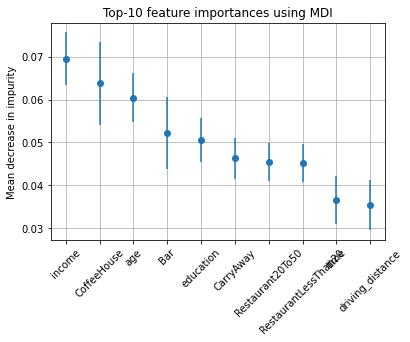

In [11]:
title = 'Top-%d feature importances using MDI' % (k)
ylabel = 'Mean decrease in impurity'

plt.title(title)
plt.ylabel(ylabel)
plt.xticks(rotation=45)
plt.grid()

plt.errorbar(feature_names, importances, std, linestyle='None', marker='o')
plt.savefig('RF_top%d_MDI_importances.png' % (k))
plt.show()